In [1]:
using Plots, Random, LinearAlgebra, Printf, StatsBase;
using DifferentialEquations, DynamicalSystems;
using BenchmarkTools;

# julia RungeKutta4 test

In [3]:
struct Lorenz96{N} end # Structure for size type
function (obj::Lorenz96{N})(dx, x, p, t) where {N}
    F = p[1]
    # 3 edge cases explicitly (performance)
    @inbounds dx[1] = (x[2] - x[N - 1]) * x[N] - x[1] + F
    @inbounds dx[2] = (x[3] - x[N]) * x[1] - x[2] + F
    @inbounds dx[N] = (x[1] - x[N - 2]) * x[N - 1] - x[N] + F
    # then the general case
    for n in 3:(N - 1)
      @inbounds dx[n] = (x[n + 1] - x[n - 2]) * x[n - 1] - x[n] + F
    end
    return nothing
end

In [4]:
# parameters and initial conditions
N = 40;
F = 8.0;
u0 = F * ones(N);
# small perturbation
u0[20] *= 1.001;

In [5]:
# create struct
lor96 = Lorenz96{N}();
ds = ContinuousDynamicalSystem(lor96, u0, [F]);

# And now evolve a trajectory
dt = 0.01; # sampling time
Tf = 30.0; # final time
tr = trajectory(ds, Tf; dt = dt);

# And plot in 3D:
x, y, z = columns(tr);
plot(x, y, z);

In [6]:
tspan = (0.0,1.0);
prob = ODEProblem(lor96,u0,tspan,[F]);
sol = solve(prob, adaptive=false, dt=0.01);
# sol = solve(prob, RK4(), adaptive=false, dt=0.01);
# sol = solve(prob, RK4(), adaptive=false, dt=0.01, saveat=0.05);

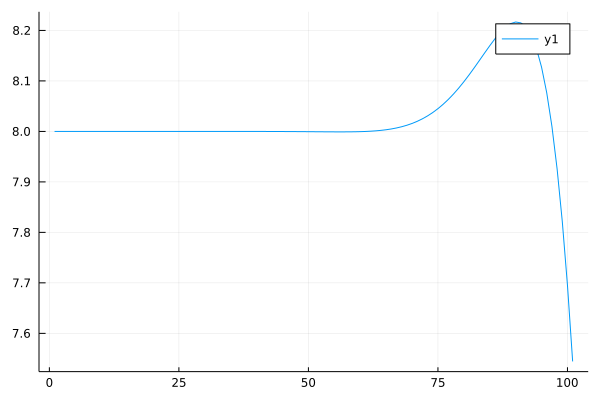

In [7]:
plot(sol[1, :])

In [8]:
size(sol)

(40, 101)

# main

In [9]:
function L96(x, F)
    N = 40
    # Setting up vector
    dx = zeros(Float64, N)
    # 3 edge cases explicitly (performance)
    @inbounds dx[1] = (x[2] - x[N - 1]) * x[N] - x[1] + F
    @inbounds dx[2] = (x[3] - x[N]) * x[1] - x[2] + F
    @inbounds dx[N] = (x[1] - x[N - 2]) * x[N - 1] - x[N] + F
    # then the general case
    for n in 3:(N - 1)
      @inbounds dx[n] = (x[n + 1] - x[n - 2]) * x[n - 1] - x[n] + F
    end
    return dx
end

L96 (generic function with 1 method)

In [10]:
function RunK4(x, dt, F)
    k1 = L96(x, F)
    x1 = x + k1 * dt/2
    k2 = L96(x1, F)
    x2 = x + k2 * dt/2
    k3 = L96(x2, F)
    x3 = x + k3 * dt
    k4 = L96(x3, F)
    return x + (k1 + 2k2 + 2k3 + k4) * dt / 6
end

RunK4 (generic function with 1 method)

## generate data

In [11]:
N = 40
F = 8.0
ratio = 0.001
year = 2
time_step = 0.01
total_step = 0.2 * 365 * year
# time = range(0.0, stop=total_step, step=time_step)

u0 = F * ones(N); # initial state
u0[20] *= 1.001;

In [12]:
tspan = (0.0, total_step);
prob = ODEProblem(lor96,u0,tspan,[F]);
# sol = solve(prob, adaptive=false, dt=0.01);
sol = solve(prob, RK4(), adaptive=false, dt=0.01, saveat=0.05);

In [13]:
size(sol)

(40, 2921)

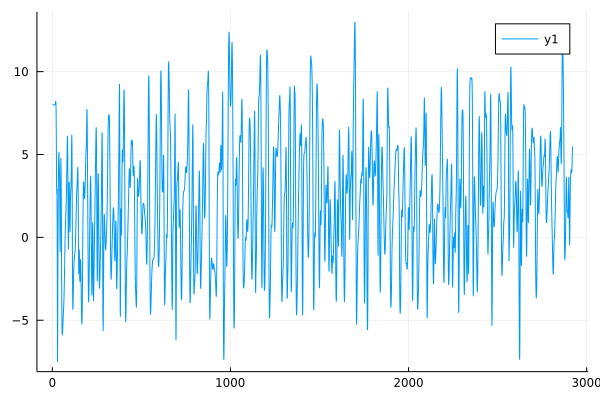

In [14]:
plot(sol[1, :])

In [15]:
_dat = @view sol[:, 1460:end];

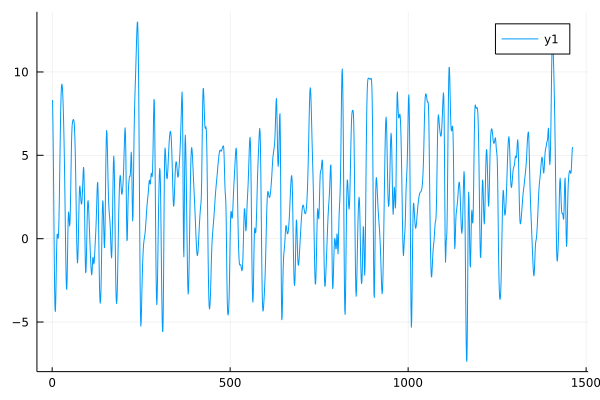

In [16]:
plot(_dat[1, :])

In [17]:
zero = zeros(Float64, (size(_dat)));
dat = _dat + zero;

In [18]:
rng = MersenneTwister(1234);
# noise = rand(rng, Float64, (size(dat)[1], size(dat)[2]))
noise = randn(rng, Float64, (size(dat)));

In [19]:
observed_dat = dat + noise;

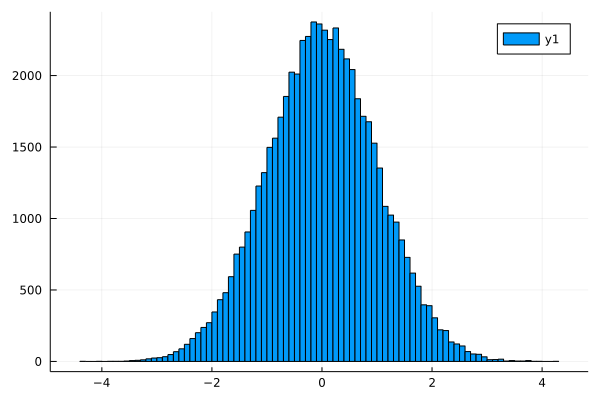

In [20]:
vec_noise = vec(noise);
histogram(vec_noise)

## info so far

In [21]:
#=
N = 40
F = 8.
time step = 0.01, array array saved every 0.05 step
dat : original data
oberved_dat : original added noise
=#

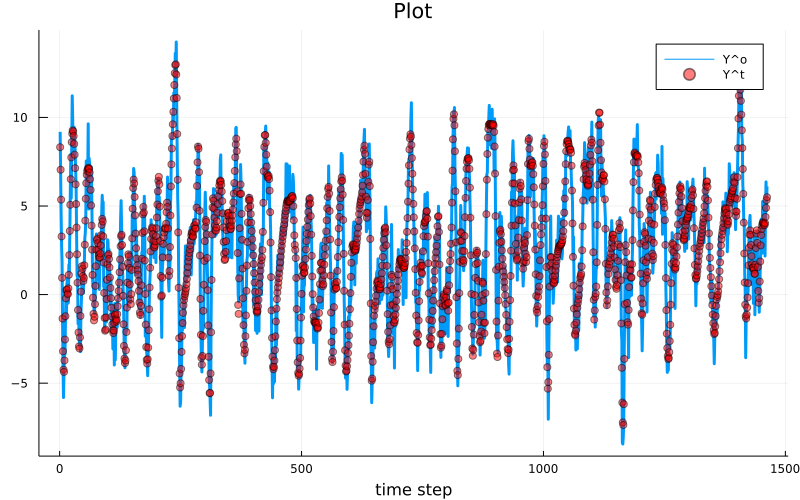

In [22]:
plot(observed_dat[1, :], title = "Plot", label = "Y^o", lw = 3, size = (800, 500))
plot!(dat[1, :], seriestype = :scatter, label="Y^t", markeralpha=0.5, color=:red)
xlabel!("time step")

## KF実装

In [23]:
# 変数
N = 40
# ajpha 共分散膨張　　↓色々変えてみる
alpha = 1.
delta = 1e-8
dt = 0.05

0.05

In [24]:
function TLM(delta, x_a, dt=0.05, N=40)
    tangentM = zeros(Float64, (N, N))
    for i in 1:N
        e_i = zeros(Float64, N)
        e_i[i] = 1
        tangentM[:, i] = (RunK4(x_a + delta * e_i, dt, 8.) - RunK4(x_a, dt, 8.)) / delta
    end
    return tangentM
end

TLM (generic function with 3 methods)

In [25]:
function one_shotKF(x_a, P_a, y_o, alpha, delta=1e-8, dt=0.05, I=I, H=I, R=I)
    M = TLM(delta, x_a)
    x_f = RunK4(x_a, dt, 8.0)
    P_f = M * P_a * transpose(M)
    P_f = P_f * alpha
    K = P_f * transpose(H) * inv(H * P_f * transpose(H) + R)
    x_a = x_f + K * (y_o - H * x_f)
    P_a = P_f - K * H * P_f
    return x_a, P_a
end

one_shotKF (generic function with 6 methods)

In [26]:
@time begin
    alpha = 1.
    x_f = observed_dat[:, 1]
    x_a = x_f
    P_a = 25I

    # KF simulation
    x_analyze = zeros(Float64, (size(dat)))
    x_analyze[:, 1] = x_f
    for i in 2:size(dat)[2]
        y_o = observed_dat[:, i]
        x_a, P_a = one_shotKF(x_a, P_a, y_o, alpha)
        x_analyze[:, i] = x_a
    end
end

  3.598484 seconds (7.06 M allocations: 1.406 GiB, 11.89% gc time, 65.07% compilation time)


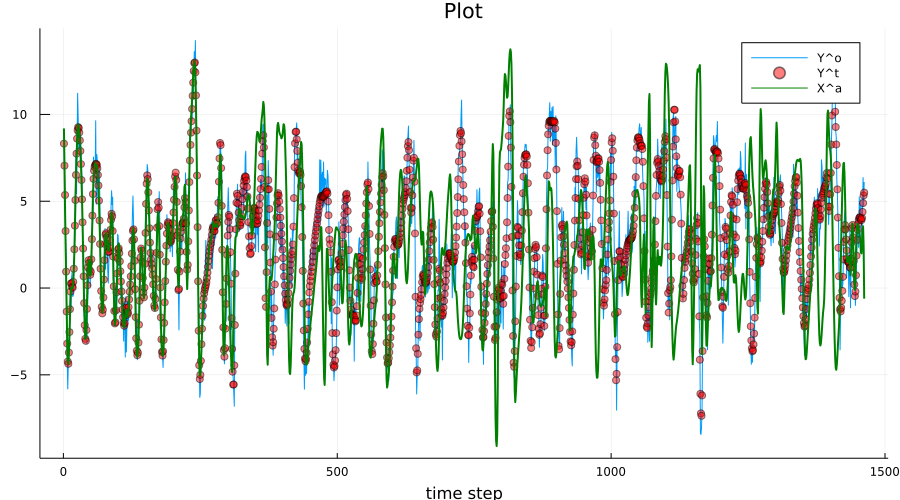

In [27]:
plot(observed_dat[1, :], title = "Plot", label = "Y^o", lw = 1, size = (900, 500))
plot!(dat[1, :], seriestype = :scatter, label="Y^t", markeralpha=0.5, color=:red)
plot!(x_analyze[1, :], label = "X^a", lw = 2, color=:green)
# plot(observed_dat[1, 1000:end], title = "Plot", label = "Y^o", lw = 1, size = (900, 500))
# plot!(dat[1, 1000:end], seriestype = :scatter, label="Y^t", markeralpha=0.5, color=:red)
# plot!(x_analyze[1, 1000:end], seriestype = :scatter, label="Y^t", markeralpha=0.5, color=:red)
# plot!(x_analyze[1, 1000:end], label = "X^a", lw = 2, color=:green)
xlabel!("time step")

In [28]:
l2dis = zeros(Float64, size(dat)[2])
for i in 1:size(dat)[2]
    l2dis[i] = rmsd(x_analyze[:, i], dat[:, i])
end

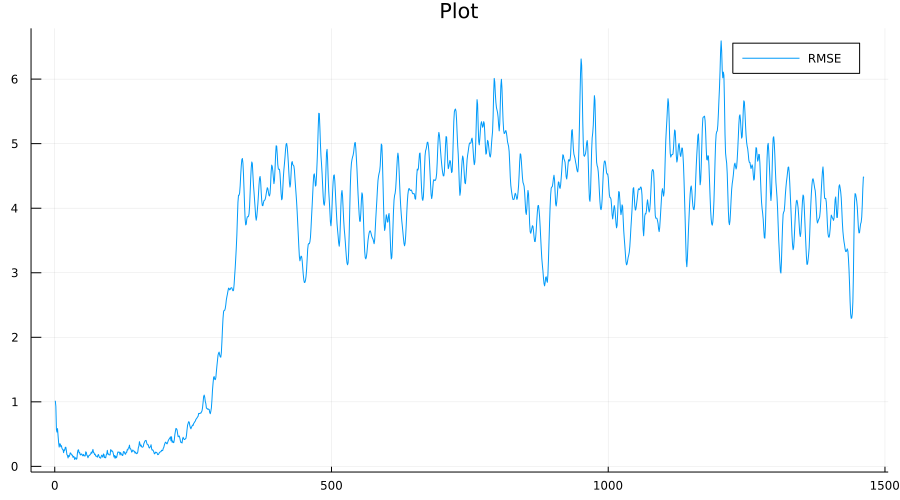

In [29]:
plot(l2dis, title = "Plot", label = "RMSE", lw = 1, size = (900, 500))

In [30]:
@time begin
    alpha_s = Float64[1., 1.025, 1.05, 1.075, 1.1, 1.125, 1.15, 1.175, 1.2]
    # alpha_s = Float64[1.175, 1.2]
    rmse = zeros(Float64, (size(alpha_s)[1], size(dat)[2]))

    for j in 1:size(alpha_s)[1]
        alph = alpha_s[j]
        x_f = observed_dat[:, 1]
        x_a = x_f
        P_a = 25I
        # KF simulation
        x_analyze = zeros(Float64, (size(dat)))
        x_analyze[:, 1] = x_f
        for i in 2:size(dat)[2]
            y_o = observed_dat[:, i]
            x_a, P_a = one_shotKF(x_a, P_a, y_o, alph)
            x_analyze[:, i] = x_a
        end
        l2dis = zeros(Float64, size(dat)[2])
        for i in 1:size(dat)[2]
            l2dis[i] = rmsd(x_analyze[:, i], dat[:, i])
        end
        rmse[j, :] = l2dis
    end
end

afaafaafaafaafaafaafaafaafa  6.937555 seconds (22.41 M allocations: 10.486 GiB, 36.35% gc time, 0.95% compilation time)


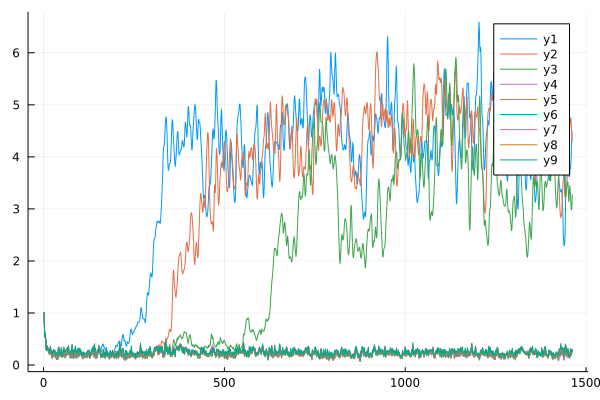

In [31]:
plot(rmse[1, :])
plot!(rmse[2, :])
plot!(rmse[3, :])
plot!(rmse[4, :])
plot!(rmse[5, :])
plot!(rmse[6, :])
plot!(rmse[7, :])
plot!(rmse[8, :])
plot!(rmse[9, :])

In [32]:
rmse_s = zeros(Float64, size(alpha_s)[1])
for i in 1:size(alpha_s)[1]
    rmse_s[i] = sum(rmse[i, :]) / size(rmse[i, :])[1]
end

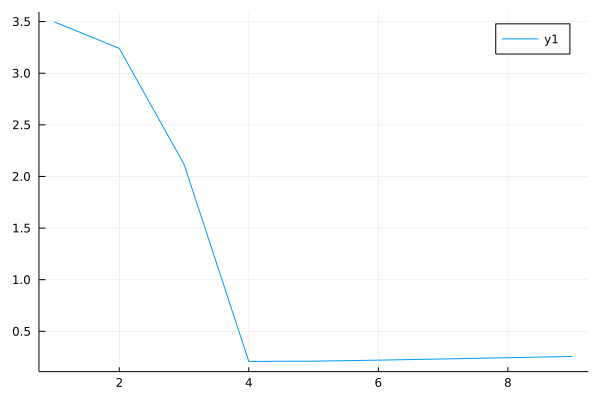

In [33]:
plot(rmse_s)

In [45]:
# using FileIO, JLD2

In [49]:
# @save "y-o.jld2" observed_dat
# @save "y-t.jld2" dat

# b = FileIO.load("myfile.jld2","a")